# Dynamical error reshaping for dual-rail erasure qubits

## Filippos Dakis  
Virginia Tech,   Nov 2025

This notebook reproduces the results shown in ["Dynamical error reshaping for dual-rail erasure qubits" arxiv.org/2510.08416](https://arxiv.org/abs/2510.08416). Hence, in order to understand, studying or at least skimming the paper is strongly recommended.

The scope of this notebook is to guide the reader through the results and explain how they where obtained. It is meant to be explamatory and pedagogical, so the reader can start from here and extend this work further. To that end, every code cell, function, and line are followed by comments.

The reader is recommended to run the cells one after the other instead of executing the whole notebook at once. 

Any feedback and suggestions are much appreciated!   dakisfilippos@vt.edu  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

The next cell contains most of the functions used in this notebook. This is the place to look for the definition, the functionality and the comments in a function. 

In [14]:
def R_rodrigues(v, theta):
    """ 
    This function uses Rodrigues rotation formula and returns a rotation matrix of angle \theta around axis v.

    Inputs:
        v       : unit vector in 3D space defining the axis of rotation
        theta   : angle of rotation
    Outputs:
        R       : rotation matrix in SO(3) 
    """
    
    v = v / np.linalg.norm(v)                                       # make sure the vector is normalized
    vx = v[0]                                                       # x component
    vy = v[1]                                                       # y component
    vz = v[2]                                                       # z component
    K = np.array([[0., -vz, vy],                                    # K matrix (see Wikipedia Rodrigues rotation formula)
                  [vz, 0., -vx],
                  [-vy, vx, 0.]])
    K2 = K @ K                                                      # K^2 matrix 
    R = np.eye(3) + np.sin(theta)*K + (1-np.cos(theta)) * K2        # final rotation matrix
    return R


def fidelity(R_g, R_u0, d = 2):
    """ 
    This function computes the fidelity between two 3x3 matrices. See Eq.(23) in 
    "An automated geometric space curve approach for designing dynamically corrected gates"

    Inputs: 
            R_g, R_u0 are two rotation matrices you want to compare and find the fidelity. One is the target, and one is the actual gate
    Outputs:
            fidelity (scalar number <=1)   
    """
    
    return (d + 1 + np.trace((R_g.T)  @ R_u0)) / (d * (d+1))


def adjoint_Representation(U):
    """ 
    This function computes the adjoint representation (3x3) of any 2x2 rotation matrix. For more information regarding
    adjoint representation see Eq.(16) in "An automated geometric space curve approach for designing dynamically corrected gates"

    Inputs:
            U: 2x2 unitary
    Outputs:
            R: 3x3 rotation matrix   
    """
    
    s_x = np.array([[0, 1],                 # Pauli X
                    [1, 0]])

    s_y = np.array([[0, -1j],               # Pauli Y
                    [1j, 0]])

    s_z = np.array([[1,  0],                # Pauli Z
                    [0, -1]])

    S = np.stack([s_x, s_y, s_z])
    
    R_U0 = np.zeros((3,3))                  # initialize the output variable
    U_dagger = U.conj().T                   # compute the dagger of the input matrix

    for p in range(0,3):                    # compute all the 3 elements of the 3x3 matrix
        for q in range(0,3):
            R_U0[p, q] = np.real( (1/2) * np.trace(U_dagger @ S[p,:,:] @ U @ S[q,:,:]) )        # Eq.(16)

    return R_U0

def expm(v, phi):
    """ 
    This function computes the exponentiation of a puli vectors with a specified angle. 
        Inputs:
                v:   axis of rotation (3-dimensional vector)
                phi: angle of rotation (rad) 
        Outputs:
                2x2 matrix 
    """
    
    s_x = np.array([[0, 1],                 # Pauli X
                    [1, 0]])

    s_y = np.array([[0, -1j],               # Pauli Y
                    [1j, 0]])

    s_z = np.array([[1,  0],                # Pauli Z
                    [0, -1]])
    
    v = v/np.linalg.norm(v)                 # make sure the axis of rotation is normalized

    return np.cos(phi)*np.eye(2) + 1j*np.sin(phi) *(v[0] * s_x + v[1]*s_y + v[2]*s_z)    # 2x2 matrix SU(2)



def print_matrix_sci(A, precision=3, width=10):
    """
    Pretty-print a 2D NumPy array in scientific notation, wrapped in an ASCII box:

      /          \
      | … matrix |
      \          /
    
    Inputs:
            A: np.ndarray, 2D array (matrix)
            precision: int, number of decimal places (default: 3)
            width: int, total width of each printed element (default: 10)
    """
    if A.ndim != 2:
        raise ValueError("Input must be a 2D array (matrix).")
    
    rows, cols = A.shape
    
    fmt = f"{{: {width}.{precision}e}}"                     # Format string for each element

    # Compute the inner width: total characters in one row
    inner_width = cols * width + (cols - 1) * 1             # spaces between elements
    
    print("/" + " " * inner_width + "\\")                   # Top border
   
    for row in A:                                           # Matrix rows
        line = " ".join(fmt.format(val) for val in row)
        print("|" + line + "|")
  
    print("\\" + " " * inner_width + "/")                   # Bottom border



import os


def load_coeffs(filename, fmt='csv', folder='.'):
    """
    Load a NumPy array from a .txt or .csv file in a specified folder.

    Inputs:
            filename: str, without extension (e.g., 'my_data')
            fmt: 'txt' or 'csv'
            folder: str, directory path to the file

    Outputs:
            arr: np.ndarray
    """
    extension = 'txt' if fmt == 'txt' else 'csv'
    full_path = os.path.join(folder, f"{filename}.{extension}")

    if not os.path.exists(full_path):
        raise FileNotFoundError(f"File '{full_path}' does not exist.")

    if fmt == 'txt':
        return np.loadtxt(full_path)
    elif fmt == 'csv':
        return np.loadtxt(full_path, delimiter=",")
    else:
        raise ValueError("Format must be 'txt' or 'csv'")  

def f_in_FS(t, cn):
    """ 
    This function computes the Fourier expansion of a given set of coefficients in a specific time window.

    Inputs:
        t   : time vector
        cn  : complex Fourier coefficients cn[i] = a[i] + j*b[i] 
    Outputs:
        f   : Fourier expansion (same dimensions as time vector t)
    """
    period        = t[-1] - t[0]                                # time windows in which we compute the Fourier expansion
    c_n_real      = np.real(cn)                                 # cosine coefs
    c_n_imaginary = np.imag(cn)                                 # sine coefs
    f             = c_n_real[0] * np.ones(len(t)) + 1j*0        # DC componenet

    for n in range(1,len(cn)):
        f += c_n_real[n] * np.cos(n * 2*np.pi * t/period) + c_n_imaginary[n] * np.sin(n * 2*np.pi *t/period)  # add order by order
   
    return f

def calculate_gate_fidelity(u_sim, u_target):
    """ 
    This function computes the average fidelity between two Quantum objects defined with qutip package. 
    Inputs: 
           u_sim: quantum object obtained upon simulation
           u_target: quantum object to compare with
    Outputs:
            fidelity (scalar number <=1)   
    """
    u_target = qt.Qobj(u_target)
    u_sim    = qt.Qobj(u_sim)

    M = (u_target.dag())*(u_sim)

    unitary_m_check = (M * (M.dag())).tr()
    unitary_m_tr_sq = (M.tr())*(M.dag().tr())

    d = M.shape[0]
    normalization = d*(d+1)

    avg_fidelity = (unitary_m_check + unitary_m_tr_sq)/normalization

    return avg_fidelity.real

def read_dict(fname, fmt ='csv', folder = 'pulses'):
    """
    Read a .csv/.txt file and extract its data in variables.

    Inputs:
            fname: str, without extension (e.g., 'my_data')
            fmt: 'txt' or 'csv'
            folder: str, directory path to the file

    Outputs:
            cn:    fourier coefficients
            speed: curve speed
            T_g:   gate time (curve length)
            ct:    torsion
            ampl:  amplitude

    """
    coeffs = load_coeffs(filename= fname, fmt = fmt, folder= folder)            # load the .csv document    
    coeffs = list(coeffs)                                                       # convert it to a list so that you can easily delete each element you get
    speed  = coeffs.pop()                                                       # get the speed of the curve
    T_g    = coeffs.pop()                                                       # gate time
    T_g    = T_g * speed
    ct     = coeffs.pop()                                                       # torsion
    ampl   = coeffs.pop()                                                       # amplitude coefficient for the curvature (see few linew below)
    coeffs = np.array(coeffs)                                                   #  
    cn     = coeffs[:len(coeffs) //2 ] + 1j* coeffs[len(coeffs) //2: ]          # Fourier coefficients

    return cn, ampl, ct, T_g, speed

    

In [15]:
# Pauli operators
I = qt.qeye(2)
X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()


II = qt.tensor(I, I)                                # two-qubit identity gate

# -------------------- Operators acting on CAVITY --------------------
X0 = qt.tensor(X, I)                                # Pauli operators acting on the cavity
Y0 = qt.tensor(Y, I)
Z0 = qt.tensor(Z, I)
# ------------------- Operators acting on TRANSMON -------------------
X1 = qt.tensor(I, X)                                # Pauli operators acting on the transmon/ancilla
Y1 = qt.tensor(I, Y)
Z1 = qt.tensor(I, Z)


N_points  = 2**12                                   # total points for curve/simulation etc


In the next couple of lines we define the Hamiltonian given in Eq.(1) of ["Dynamical error reshaping for dual-rail erasure qubits"](https://arxiv.org/abs/2510.08416).We will use this Hamiltonian to obtain the joint parity gate, and then compare our results against this two-qubit gate.

Hamiltonian: 
$$ H = \frac{g_{bs}}{2}(a^\dagger b + ab^\dagger) + \frac{\chi}{2}a^\dagger a \sigma_z$$

Beamsplitter coupling strength: $g_{bs} = \frac{\sqrt{3}}{2}|\chi|$,

Gate time: $T_{\rm gate} = 2\pi/|\chi|$

For the derfivation see Appendix E in [Dual-rail encoding with superconducting cavities](https://www.pnas.org/doi/10.1073/pnas.2221736120)

First, we examine the case of zero photons in the cavities, which should lead to an identity gate on transmon, $I_1\otimes I_2$.

In [16]:
# This chi is our reference. We set it χ=1 for simplicity

chi    = 1                                              # MHz,  dispersive coupling χ

g_chi  = (np.sqrt(3)/2)* np.abs(chi)                    # MHz,  g coupling (bemasplitter)

t_gate_ref = 2*np.pi/np.abs(chi)                        # gate time   t = 2*pi/|χ|

"""                 chi_    = chi * t_gate                              # normalized coeeficients
                    g_chi_  = g_chi * t_gate                            # 
"""

time_gate_ref_ = np.linspace(0,t_gate_ref, N_points)    # time 

# First, we do everything step-by-step and later we will combine them together and have a fair comparison.
#
# ---- Square pulse Hamiltonian for 0 photons in the cavities |00> -----------------

H_square_pulse_0 = [[Z1/2, -chi*0]]          # Hamiltonian.   See Eq.(S29-S30) in "Dynamical error reshaping for dual-rail erasure qubits"

H_square_pulse_0 = qt.QobjEvo(H_square_pulse_0, tlist=time_gate_ref_)

U_square_pulse_0  = qt.propagator(H_square_pulse_0, t=time_gate_ref_, args=None, options={'max_step': 0.1/N_points,'atol': 1e-14,'rtol': 1e-14})


print("Infidelity = ", abs(1- calculate_gate_fidelity(U_square_pulse_0[-1], II) ) )   # compute and print the infidelity


U_square_pulse_0[-1]        # gate at time t = T_g 

Infidelity =  0.0


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Second, we examine the case of one photon in the cavities, which should lead to a $Z$ gate on transmon, $I_1\otimes Z_2$.

In [17]:
# ---- Square pulse Hamiltonian for 1 photon in the cavities (|01>, |10>) -----------------

H_square_pulse = [[X0/2,     g_chi], 
                  [Z1/2,    -chi/2], 
                  [Z0*Z1/2, -chi/2]]          # Hamiltonian  See Eq.(S29-S30) in "Dynamical error reshaping for dual-rail erasure qubits"

H_square_pulse = qt.QobjEvo(H_square_pulse, tlist=time_gate_ref_)

U_square_pulse  = qt.propagator(H_square_pulse, t=time_gate_ref_, args=None, options={'max_step': 0.1/N_points,'atol': 1e-14,'rtol': 1e-14})


print("Infidelity = ", abs(1- calculate_gate_fidelity(U_square_pulse[-1], Z1) ) )       # compute and print the infidelity


U_square_pulse[-1]          # gate at time t = T_g 

Infidelity =  2.0650148258027912e-14


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.14606533e-11-1.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -9.93576953e-12-1.23807442e-14j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.14606533e-11+1.00000000e+00j
   0.00000000e+00+0.00000000e+00j  9.93576953e-12-1.23807442e-14j]
 [-9.94636382e-12-1.63169371e-15j  0.00000000e+00+0.00000000e+00j
  -4.74801890e-15-1.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.94636382e-12-1.63169371e-15j
   0.00000000e+00+0.00000000e+00j -4.74801890e-15+1.00000000e+00j]]

As you can see, the above results demonstrate a rotation on the transmon/acilla conditional to the number of photons stored in the cavities. We used a noise-free Hamiltonian for the above gate and thus we achieved a non-demolition parity measurement with fidelity 1. We will see later on how this gate performs in the presence of dephasing noise.

Before we proceed, one can play a bit with the adjoint representation and see how SU(2) transforms to SO(3).

In [18]:
# ------ choose the gate in SU(2) representation -------------
n_target   = [0,0,1]                                                        # rotation axis 
phi_target = np.pi/2                                                        # angle, keep in mind the double cover !!! 
U_target   = expm(n_target, phi_target/2)                                   # U = exp(1j * phi * n \dot sigma_pauli)


R_target   = adjoint_Representation(U_target)                               # R is the adjoint representation

print(" ------------ U_target -----------")
print(U_target)
print(" ---------------------------------\n")

print(" ------------ R_target -----------")
print_matrix_sci(R_target)
print(" ---------------------------------")

 ------------ U_target -----------
[[0.70710678+0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678-0.70710678j]]
 ---------------------------------

 ------------ R_target -----------
/                                \
| 0.000e+00  1.000e+00  0.000e+00|
|-1.000e+00  0.000e+00  0.000e+00|
| 0.000e+00  0.000e+00  1.000e+00|
\                                /
 ---------------------------------


In order to have dephasing robust gates we came up with a different protocol. Instead of using the above gates, we implement the joint parity unitary as a three-part composite sequence in which each segment cancels dephasing to first order, yielding a dynamically corrected $U_{\rm JP}$ with quartic sensitivity to noise.You can see the steps gate in Figure 1(b).

The first and third steps are identical. Here we define the conditional $ZZ(\pi/2)$ gate we use in these steps.

Rz_pi_2 

 ----------------- U_target ----------------

[[0.70710678+0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678-0.70710678j]] 

 -------------------------------------------


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.07106917e-01-7.07106646e-01j -2.53095187e-09-1.11688936e-07j]
 [ 2.53095187e-09-1.11688936e-07j -7.07106917e-01+7.07106646e-01j]]

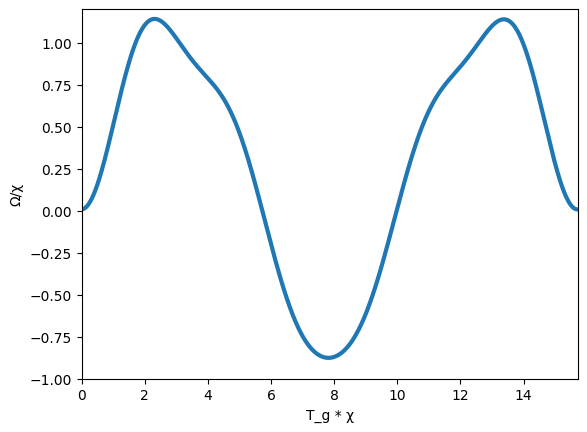

In [20]:
os.getcwd()

name = 'Rz_pi_2'

print(name,"\n")

# ------ choose the gate in SU(2) representation -------------
n_target   = [0,0,1]                                                        # rotation axis 
phi_target = np.pi/2                                                        # angle, keep in mind the double cover !!! 
U_target   = expm(n_target, phi_target/2)                                     # U = exp(1j * phi * n \dot sigma_pauli)

print(" ----------------- U_target ----------------\n")
print(U_target,"\n")
print(" -------------------------------------------")

cn, ampl, ct, T_g, speed = read_dict(name)                                  # read the coefficients from the csv file 

time      = np.linspace(0, T_g, N_points)                                   # time vector, T_g is the gate tiem

pulse     = ampl *np.real(f_in_FS(time, cn))                                # the curvature, cn are the Fourier coefficients, ampl is a multiplicative coeff as an extra degree of freedom

# control fields
omega = pulse                                                               # driving along X-axis
phi   = 0                                                                   # phase filed
delta = ct                                                                  # detuning, ct is the torsion


T_g_times_chi = 2 * ct * T_g / chi                                          # gate time for the ZZ(pi/2) between cavity a and transmon

time_gate_1 = np.linspace(0, T_g_times_chi, N_points) 


# normalized parameters w.r.t.  χ  
x_control = omega * chi / (2*ct)                                            # normalized (w.r.t. \chi) control along X-axis                                    
y_control = np.zeros_like(x_control)                                        # normalized (w.r.t. \chi) control along Y-axis
z_control = chi/2                                                           # normalized (w.r.t. \chi) control along Z-axis


H_total_0 = [[X/2, x_control], 
             [Y/2, y_control], 
             [Z/2, z_control]]          # Hamiltonian  See Eq.(S32) in "Dynamical error reshaping for dual-rail erasure qubits"

H_total_0 = qt.QobjEvo(H_total_0, tlist=time_gate_1)                           # quantum object

result_0 = qt.propagator(H_total_0, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator 


# print(T_g_times_chi)

plt.plot(time_gate_1 * chi, x_control / chi, linewidth = 3.)            # plot the pulse 
plt.xlabel("T_g * χ")
plt.ylabel("Ω/χ")
plt.xlim([0,T_g_times_chi * chi])
plt.ylim([-1, 1.20])
# plt.savefig("R_z_pi_4_curvature_wrt_chi.svg")

R_z_pi_over_2_0photon = result_0[-1]

R_z_pi_over_2_0photon                                                   # Rz(pi/4) on transmon 


Now let's compute the fidelity of the **Parity measurement** operation when there are **0 photons** in the cavity. That said, the cavities are in the global ground state $\ket{00}$ and so the $X$ operation on the beamsplitter will act as "Identity" on the cavities. In other words, the gate we are interested in is of the form 
$\begin{equation}
    U_0 = R_{z}(\pi/2) \,\, X_{\rm cav}\,\, R_{z}(\pi/2) = \ket{00}\bra{00}\otimes I_2 
\end{equation}$

In [21]:
U_sim_0 = R_z_pi_over_2_0photon  * Z * R_z_pi_over_2_0photon        # U_0 = R_z(pi/4) * X_cavity # R_z(pi/4) = |00><00| (x) Z_{transmon}
fid_0   = calculate_gate_fidelity(U_sim_0, I)                       # gate fidelity
print(" ----------------- Infidelity ----------------\n")
print("             ",1 - fid_0, "\n")
print(" ---------------------------------------------")

U_sim_0/1j                                                          # Up to a global phase, here the global phase is   1j

 ----------------- Infidelity ----------------

              7.72715225139109e-14 

 ---------------------------------------------


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00-3.82974017e-07j  3.57930577e-09+1.57951978e-07j]
 [-3.57930577e-09+1.57951978e-07j  1.00000000e+00+3.82974017e-07j]]

Let's test the robustness against the dephasing noise of this gate. We make a fair comaprison since we defien $\gamma$ w.r.t. $\chi$, and thus longer gates acquire more noise.

In [22]:
noise_points = 50

gamma = np.logspace(-3, 0, noise_points)                            # noise parameter

gamma_over_chi = gamma * chi                                        # γ/χ = 3   ---->  γ = 3*χ

fid_Rz_pi_4_0photons = np.zeros(noise_points)                       # initialize array for later use
fid_0_noisy          = np.zeros(noise_points)                       # initialize array for later use


# loop for robust gates
for q in range(0,noise_points):
 
    H_0_noisy      = [[X/2, x_control], 
                      [Y/2, y_control], 
                      [Z/2, z_control], 
                      [Z/2, gamma_over_chi[q]]]                                            # Hamlitonian with \gamma * chi noise ternm
    
    H_0_noisy      = qt.QobjEvo(H_0_noisy, tlist=time_gate_1)                                                                                 # quantum object

    result_0_noisy = qt.propagator(H_0_noisy, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})       # run the simulator 

    fid_Rz_pi_4_0photons[q] = np.abs(calculate_gate_fidelity(result_0_noisy[-1], U_target))          # fidelity of Rz_(pi/4) 

    U_sim_0_noisy  = result_0_noisy[-1] * Z * result_0_noisy[-1]                            # final gate on the transmon, Z gate

    fid_0_noisy[q] = np.abs(calculate_gate_fidelity(U_sim_0_noisy, I))                      # fidelity of the I gate



fid_square_pulse = np.zeros(noise_points)                                   # initialize array for later use
# normalized parameters
# z_control  suct that z_control_square * T_gate  same as the peak value of \Omega_x in the robust case
# here is approximately 1
z_control_square = -chi *0         # -2.25 * chi                            # normalized control along Z-axis

# loop for square pulses
for q in range(0,noise_points):

    H_0_square    = [[Z1/2, z_control_square + gamma_over_chi[q]]]                          # square pulse Hamiltonian

    H_0_square    = qt.QobjEvo(H_0_square, tlist=time_gate_ref_)                            # quantum object

    result_square = qt.propagator(H_0_square, t=time_gate_ref_, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator 

    fid_square_pulse[q] = np.abs(calculate_gate_fidelity(result_square[-1], II))            # fidelity for noise \gamma



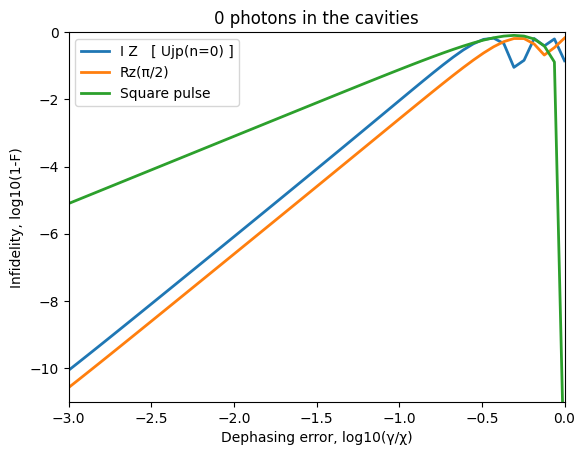

In [24]:
fig, ax = plt.subplots()
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_0_noisy)), linewidth = 2, label = "I Z   [ Ujp(n=0) ]")
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Rz_pi_4_0photons)), linewidth = 2, label = "Rz(π/2)")
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_square_pulse)), linewidth = 2, label = "Square pulse")
#ax.plot(np.log10(gamma_Tg), np.log10(gamma_Tg**4 / (72 * 1000000)))
ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("0 photons in the cavities")
ax.set_ylim([-11, 0])
ax.set_xlim([-3, 0])
ax.legend();

#fig.savefig("0_photons_in_cav_ZZ_wrt_chi.svg")


Next, we use the **EXACT SAME GATE** for the single-photon subspace.

In [ ]:
H_total_1 = [[X1/2,    x_control], 
             [Z0*Z1/2, z_control]]       # Hamiltonian with coupling g = 0.  See Eq.(S32) in "Dynamical error reshaping for dual-rail erasure qubits"

H_total_1 = qt.QobjEvo(H_total_1, tlist= time_gate_1)           # quantum object 

result_1 = qt.propagator(H_total_1, t = time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-15,'rtol': 1e-15})      # run the simulator 

R_z_pi_over_2_1photon = result_1[-1]                  # Gate

print("The gate on transmon when we operate within the codespace:")

R_z_pi_over_2_1photon


The gate on transmon when we operate within the codespace:


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.07106917e-01-7.07106646e-01j -2.53095803e-09-1.11688968e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 2.53095803e-09-1.11688968e-07j -7.07106917e-01+7.07106646e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -7.07106917e-01+7.07106646e-01j  2.53095803e-09-1.11688968e-07j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.53095803e-09-1.11688968e-07j -7.07106917e-01-7.07106646e-01j]]

Apply the protocol shown in Fig. 1(b)
$\begin{equation}
U_1 = R_{z}(\pm\pi/2) \,\, X_{\rm cav}Z_2\,\, R_{z}(\mp\pi/2) = X_1 \otimes Z_2
\end{equation}$

This is the final gate:

In [26]:
U_sim_1 =  R_z_pi_over_2_1photon * X0*Z1 * R_z_pi_over_2_1photon   # U_1 = R_z(-pi/4) * X_cavity # R_z(-pi/4) = X (x) I_transmon}
#                                                                        here the X-gate is IDEAL or instataneous, in other words coupling  g ---> inf !!!
fid_1   = calculate_gate_fidelity(U_sim_1, X0*Z1)                  # gate fidelity
print(" ----------------- Infidelity ----------------\n")
print("             ",1 - fid_1, "\n")
print(" ---------------------------------------------")
U_sim_1                                                            # no global phase here

 ----------------- Infidelity ----------------

              2.3425705819590803e-14 

 ---------------------------------------------


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00-5.55111512e-16j -3.57931586e-09-3.57931449e-09j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -3.57931586e-09+3.57931449e-09j -1.00000000e+00-5.55111512e-16j]
 [ 1.00000000e+00+5.55111512e-16j  3.57931586e-09-3.57931449e-09j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 3.57931586e-09+3.57931449e-09j -1.00000000e+00+5.55111512e-16j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]

Now, let's put everything together and see how the joint parity gate (with ideal itermediate step 2) performs against the noise.

In [27]:
from scipy.linalg import block_diag

U_JP = qt.Qobj( block_diag(U_sim_0.full(), U_sim_1.full()) )                # full joint parity gate

u_jp_target = qt.Qobj( block_diag(1j*I.full(), (X0*Z1).full()) )            # Joint parity target for the cavity space {|00>,|01>,|10> }


fid_Ujp_noise_free   = calculate_gate_fidelity(U_JP, u_jp_target)           # compute fidelity

print(" ----------------- Infidelity of Joint Parity ----------------\n")
print("             ",1 - fid_Ujp_noise_free, "\n")
print(" ---------------------------------------------")

U_JP                                                                        # joint parity gate see Eq.(4) (P_{11} is not shown here)

 ----------------- Infidelity of Joint Parity ----------------

              5.229150445984487e-14 

 ---------------------------------------------


Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 3.82974017e-07+1.00000000e+00j -1.57951978e-07+3.57930577e-09j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-1.57951978e-07-3.57930577e-09j -3.82974017e-07+1.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00-5.55111512e-16j -3.57931586e-09-3.57931449e-09j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -3.57931586e-09+3.57931449e-09j -1.00000000e+00-5.55111512e-16j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.00000000e+00+5.55111512e-16j  3.579

Now let's test the noise robustness of this gate where $X_{\rm cav}$ is ideal, ie $g \rightarrow \inf$ ! Later on we have simulations with finite and smooth $g(t)$ coupling.

In [28]:
noise_points = 50

gamma = np.logspace(-3, 0, noise_points)                            # noise parameter

gamma_over_chi = gamma * chi                                        # γ/χ = 3   ---->  γ = 3*χ

fid_1_noisy     = np.zeros(noise_points)                            # initialize array for later use
fid_1_sqr_noisy = np.zeros(noise_points)

# loop for robust gates
for q in range(0,noise_points):
 
    H_1_noisy      =  [[X1/2, x_control], 
                       [Z0*Z1/2, z_control], 
                       [Z1/2, gamma_over_chi[q]]]                   # Hamiltonian with coupling g = 0
    
    H_1_noisy      = qt.QobjEvo(H_1_noisy, tlist = time_gate_1)                                                                                 # quantum object

    result_1_noisy = qt.propagator(H_1_noisy, t = time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})       # run the simulator 

    U_sim_1_noisy  = result_1_noisy[-1] * X0*Z1 * result_1_noisy[-1]                        # final gate on the transmon (with ideal step 2), Z gate

    fid_1_noisy[q] = np.abs(calculate_gate_fidelity(U_sim_1_noisy, X0*Z1))                  # fidelity againsta X_1\otimes Z_2

    # ---------------------------------------------------------------------------------------------------

    H_square_pulse_1 = [[X0/2, g_chi], 
                        [Z1/2, -chi/2], 
                        [Z0*Z1/2, -chi/2],
                        [Z1/2, + gamma_over_chi[q]]]                # hamiltonian 

    H_square_pulse_1 = qt.QobjEvo(H_square_pulse_1, tlist=time_gate_ref_)

    U_square_pulse_1  = qt.propagator(H_square_pulse_1, t=time_gate_ref_, args=None, options={'max_step': 0.1/N_points,'atol': 1e-14,'rtol': 1e-14})

    fid_1_sqr_noisy[q] = np.abs(calculate_gate_fidelity(U_square_pulse_1[-1], Z1))      # compute fidelity against I_1 \otimes Z_2



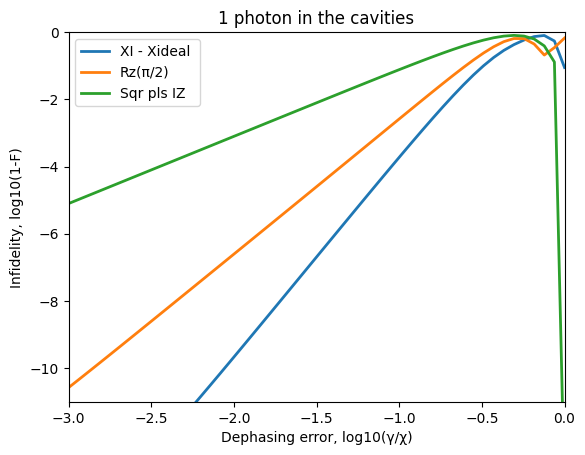

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_1_noisy)), linewidth = 2, label = "XI - Xideal ")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Rz_pi_4_0photons)), linewidth = 2, label = "Rz(π/2)")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_1_sqr_noisy)), linewidth = 2, label = "Sqr pls IZ ")

#ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **2  *8), linewidth = 2, label = "4-order")     # uncomment these lines 
                                                                                                                        
#ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **4  *20), linewidth = 2, label = "4-order")    # to see how infidelity

#ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **6  *200), linewidth = 2, label = "6-order")   # scales against the noise.

ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("1 photon in the cavities")
ax.set_ylim([-11, 0])
ax.set_xlim([-3, 0])
ax.legend();

# fig.savefig("1_photons_in_cav_ZZ_wrt_chi.svg")

In the above figure, the Square pulse (green) is non-robust against dephasing noise and thus infidelity scales with $\propto \gamma^2$. As per our protocol, the first and third step consist of a conditional $Z$ rotation between cavity $a$ and transmon which translate to an $R_{z}(\pm\pi/2)$ gate (Fig. S1 (b)) on transmon conditional to the the number of photons in the cavity. Hence, in the above plot, $R_z(\pi/2)$ shows the robustness of these gates designed few cells above. Infidelity of $R_z(\pm \pi/2)$ scales with $\propto \gamma^4$ showing robustness to first order. Finally, we plot the whole protocol assuming an ideal (zero gate time, infinite field strength) $X_1\otimes Z_2$ during the second step revealing a hidden "spin echo" type noise cancellation and thus leading to noise robustness to second order in $\gamma$, and thus infidelity scales with $\propto \gamma^6$. This is also a reason why we choose to have an $X_1\otimes Z_2$ in step two, instead of $X_1 \otimes I_2$. For more details see Supplementary Material.

Next, we proceed by defining a more realistic approach for the $X_1\otimes Z_2$. To that end, we used [BARQ (arXiv:2503.11492)](https://arxiv.org/abs/2503.11492) and specifically [QURVEROS](https://github.com/evpiliouras/qurveros) package to obtain smooth and experimentally friendly pulses. For more information about the conditions and constaints see the main paper. 

In [34]:
name = 'pulses/XZ_gate_gauss_and_barq.csv'                                                # name of the .csv file with the transmon fields


omega_x, omega_tr, phi_tr, delta_tr = np.loadtxt(name, delimiter=",").T    # load the fields on the variables

# normalized parameters
x_g = omega_x * chi                                                         # normalized control along X-axis FOR THE CAVITY. Gaussian pulse. See Fig. 3 (a)
y_g = np.zeros_like(omega_x)                                                # normalized control along Y-axis FOR THE CAVITY
z_g = np.zeros_like(omega_x)                                                # normalized control along Z-axis FOR THE CAVITY

# normalized parameters
x_tr = omega_tr * np.cos(phi_tr) * chi                                      # normalized control along X-axis   See Fig. 3 (b)                                      
y_tr = omega_tr * np.sin(phi_tr) * chi                                      # normalized control along Y-axis   See Fig. 3 (b)
z_tr = delta_tr * chi                                                       # normalized control along Z-axis   See Fig. 3 (b)

time_g_tr      = np.linspace(0, 1/chi, N_points)                            # time vector for X_1 Z_2 gate

H_g_tr = [[X0/2, x_g ], [Y0/2, y_g ], [Z0/2, z_g ], 
          [X1/2, x_tr], [Y1/2, y_tr], [Z1/2, z_tr], [Z0*Z1/2, 0.0]]         # Hamiltonian.  See Eq.(S32) in "Dynamical error reshaping for dual-rail erasure qubits"

H_g_tr = qt.QobjEvo(H_g_tr, tlist = time_g_tr)

result_g_tr = qt.propagator(H_g_tr, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})       # simulator

fid_g_tr = calculate_gate_fidelity(result_g_tr[-1], X0*Z1)                  # two-qubit gate fidelity

print(" ----------------- Infidelity ----------------\n")
print("             ",1 - fid_g_tr, "\n")
print(" ---------------------------------------------")

U_XZ = result_g_tr[-1]                                                      # final gate

result_g_tr[-1]


 ----------------- Infidelity ----------------

              2.5013324744804777e-13 

 ---------------------------------------------


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-4.93586964e-15-3.86100387e-15j  5.50703105e-16-3.29582809e-15j
   1.00000000e+00-5.83326882e-07j -1.62557641e-11-2.61585980e-11j]
 [-5.50703105e-16-3.29582809e-15j -4.93586964e-15+3.86100387e-15j
  -1.62557641e-11+2.61585980e-11j -1.00000000e+00-5.83326882e-07j]
 [ 1.00000000e+00-5.83326882e-07j -1.62557641e-11-2.61585980e-11j
  -4.93586964e-15-3.86100387e-15j  5.50703105e-16-3.29582809e-15j]
 [-1.62557641e-11+2.61585980e-11j -1.00000000e+00-5.83326882e-07j
  -5.50703105e-16-3.29582809e-15j -4.93586964e-15+3.86100387e-15j]]

When the system is in the code space $\{\ket{01},\ket{10}\}$, the joint parity gate yields to $X_1\otimes Z_2$ (with finite $g$ coupling) and in the absence of noise the fage fidelity is given below.

In [35]:
fid_1g = calculate_gate_fidelity(R_z_pi_over_2_1photon * result_g_tr[-1] * R_z_pi_over_2_1photon , X0*Z1)
print(" ----------------- Infidelity ----------------\n")
print("             ",1 - fid_1g, "\n")
print(" ---------------------------------------------")


 ----------------- Infidelity ----------------

              2.737809978725636e-13 

 ---------------------------------------------


Now let's see how this responds to the noise.

In [39]:
noise_points = 200

gamma = np.logspace(-3,0, noise_points)                                         # noise parameter

gamma_over_chi = gamma * chi

fid_Ujp_Z_ZZ_robust_0photon  = np.zeros_like(gamma)                             # initialize array for later use
fid_Ujp_Z_ZZ_robust_1photon  = np.zeros_like(gamma)                             # initialize array for later use

fid_Ujp_sqr_pls_yale_0photon = np.zeros_like(gamma)                             # initialize array for later use                        
fid_Ujp_sqr_pls_yale_1photon = np.zeros_like(gamma)                             # initialize array for later use

fid_Ujp_Z_ZZ_full = np.zeros_like(gamma)                                        # initialize array for later use
fid_Ujp_sqr_full  = np.zeros_like(gamma)                                        # initialize array for later use


u_jp_full_target = qt.Qobj( block_diag(-1*I.full(), (X0*Z1).full()) )           # u_jp target for my robust gate    6x6

u_jp_full_sqr_target = qt.Qobj( block_diag( I.full(), 1j*Z1.full()) )           # U_jp target for yale sqr pulse    6x6


""" Dispersive coupling during the second step. See Eq. (S33) """

ksi = 0.0 * chi            # set this value to be {0., 0.01, 0.1, 0.5, 1.}        # cross-talk on step #2   <====================================



print("ZZ Crosstalk value is ξ/χ = ", ksi/chi)

for q in range(0,noise_points):

    # -----------------------------------------------
    # Rz(π/4) for ZER0-photon subspace  ROBUST

    H_total_0 = [[X/2, x_control], 
                 [Y/2, y_control], 
                 [Z/2, z_control + gamma_over_chi[q]]]              # Hamiltonian

    H_total_0 = qt.QobjEvo(H_total_0, tlist=time_gate_1)            # quantum object

    result_0 = qt.propagator(H_total_0, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator 
    # -----------------------------------------------

    # -----------------------------------------------
    # Z gate for single-photon subspace ROBUST

    H_g_tr_0 = [[X/2, x_tr], 
                [Y/2, y_tr], 
                [Z/2, z_tr + gamma_over_chi[q]]]

    H_g_tr_0 = qt.QobjEvo(H_g_tr_0, tlist = time_g_tr)

    result_g_tr_0 = qt.propagator(H_g_tr_0, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
    # -----------------------------------------------

    # U_jp ZER0-photon subspace FIDELITY
    U_JP_0photon = result_0[-1] * result_g_tr_0[-1] * result_0[-1]                              # Matrix 2x2 

    fid_Ujp_Z_ZZ_robust_0photon[q] = np.abs(calculate_gate_fidelity(U_JP_0photon, I)) 



    # one photons -- Robust  Ujp
    # -----------------------------------------------
    # ZZ(π/2) for single-photon subspace  ROBUST

    H_total_1 = [[X1/2, x_control], 
                 [Z0*Z1/2, z_control + gamma_over_chi[q]]]       # Hamiltonian with coupling g = 0.

    H_total_1 = qt.QobjEvo(H_total_1, tlist= time_gate_1)        # quantum object 

    result_1 = qt.propagator(H_total_1, t = time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-15,'rtol': 1e-15})      # run the simulator 
    # -----------------------------------------------

    # -----------------------------------------------
    # XZ gate for single-photon subspace ROBUST

    H_g_tr = [[X0/2,   x_g ], [Y0/2, y_g ], [Z0/2, z_g], 
              [X1/2,   x_tr], [Y1/2, y_tr], [Z1/2, z_tr + gamma_over_chi[q]], 
              [Z0*Z1/2, ksi]]

    H_g_tr = qt.QobjEvo(H_g_tr, tlist = time_g_tr)

    result_g_tr = qt.propagator(H_g_tr, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
    # -----------------------------------------------

    # U_jp single-photon subspace FIDELITY
    U_JP_1photon = result_1[-1] * result_g_tr[-1] * result_1[-1]                    # Matrix 2x2     

    fid_Ujp_Z_ZZ_robust_1photon[q] = np.abs(calculate_gate_fidelity(U_JP_1photon, X0*Z1)) 


    # ----- Fidelity of the full 6x6 matrix

    U_jp_robust_full = qt.Qobj( block_diag(U_JP_0photon.full(), U_JP_1photon.full()) )      # Full 6x6 matrix

    fid_Ujp_Z_ZZ_full[q] = calculate_gate_fidelity(U_jp_robust_full, u_jp_full_target)      # fidelity of the full 6x6 matrix
    



# zero photons -- Square pulse  Ujp
for q in range(0,noise_points):

    # Yale square pulse 
    H_square_pulse_0 = [[Z/2, -chi  + gamma_over_chi[q]]]

    H_square_pulse_0 = qt.QobjEvo(H_square_pulse_0, tlist=time_gate_ref_)

    U_JP_sqr_pls_0photon  = qt.propagator(H_square_pulse_0, t=time_gate_ref_, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14} )

    fid_Ujp_sqr_pls_yale_0photon[q] = np.abs(calculate_gate_fidelity(U_JP_sqr_pls_0photon[-1], I)) 

    # one photons -- Square pulse  Ujp
    # Yale square pulse 
    H_square_pulse_1 = [[X0/2, g_chi], 
                        [Z1/2, -chi/2  - gamma_over_chi[q]], 
                        [Z0*Z1/2, -chi/2]]          # hamiltonian 

    H_square_pulse_1 = qt.QobjEvo(H_square_pulse_1, tlist=time_gate_ref_)

    U_JP_sqr_pls_1photon  = qt.propagator(H_square_pulse_1, t=time_gate_ref_, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14} )

    fid_Ujp_sqr_pls_yale_1photon[q] = np.abs(calculate_gate_fidelity(U_JP_sqr_pls_1photon[-1], Z1)) 


    # ----- Fidelity of the full 6x6 matrix

    U_jp_sqr_pls_full = qt.Qobj( block_diag(U_JP_sqr_pls_0photon[-1].full(), U_JP_sqr_pls_1photon[-1].full()) )     # Full 6x6 matrix

    fid_Ujp_sqr_full[q] = calculate_gate_fidelity(U_jp_sqr_pls_full, u_jp_full_sqr_target)                          # fidelity of the full 6x6 matrix

    

ZZ Crosstalk value is ξ/χ =  0.0


Left figure shows the infidelity of the block-matrices/gates creating the larger one.

Right figure shows the infidelity of the joint parity gate

C:\Users\dakis\AppData\Local\Temp\ipykernel_27952\2856502314.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_sqr_pls_yale_0photon)), linewidth = 2, label = "Sqr Ujp I 0phot")


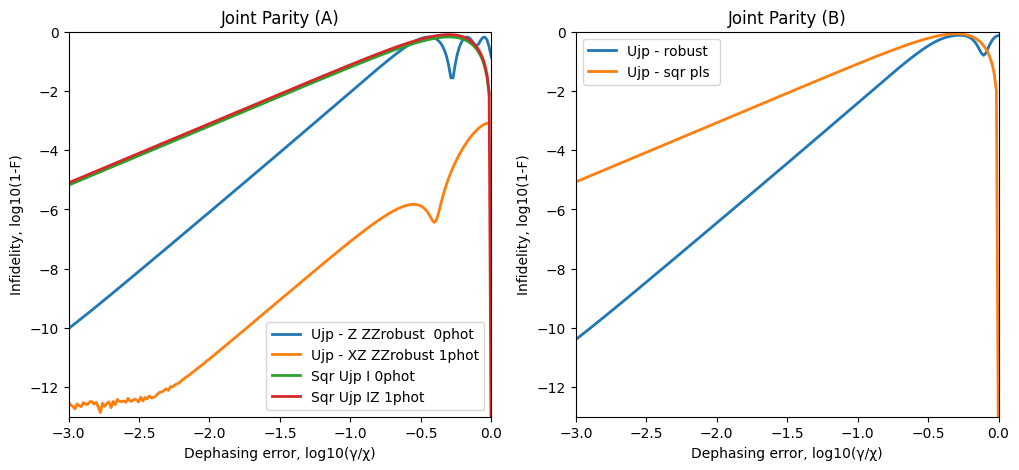

In [40]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_Z_ZZ_robust_0photon)), linewidth = 2, label = "Ujp - Z ZZrobust  0phot")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_Z_ZZ_robust_1photon)), linewidth = 2, label = "Ujp - XZ ZZrobust 1phot")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_sqr_pls_yale_0photon)), linewidth = 2, label = "Sqr Ujp I 0phot")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_sqr_pls_yale_1photon)), linewidth = 2, label = "Sqr Ujp IZ 1phot")

# ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **2  *8), linewidth = 2, label = "2-order")

# ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **4  /100000), linewidth = 2, label = "4-order")

# ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **6  /1000), linewidth = 2, label = "6-order")

ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("Joint Parity (A)")
ax.set_ylim([-13, 0])
ax.set_xlim([-3, 0])
ax.legend();


ax = fig.add_subplot(122)

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_Z_ZZ_full)), linewidth = 2, label = "Ujp - robust ")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_sqr_full)), linewidth = 2, label = "Ujp - sqr pls ")

ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("Joint Parity (B)")
ax.set_ylim([-13, 0])
ax.set_xlim([-3, 0])
ax.legend();

# fig.savefig("U_jp_dephasing_wrt_chi__step2_ksi_1chi.svg")

Now, we can take a break and show how square pulses can cancel $ZZ$ crosstalk (or $XX$, $YY$ crosstalks up to a rotation). We make this claim in the main text and the supplementary material so here we have an example of an $XX$ gate robust to $ZZ$ quasistatic noise to first order. For more dertails, see Section II in Supplementary Material, Eqs. (S20) - (S27).

The geometric condition is given in Eq. (S27) depicting the need for two 3D curves with orthogonal tangent components in the interval $t\in [0,T_g]$. Of course, the same condition is used for the mroe complicated $X_1\otimes Z_2$ gate derived above.

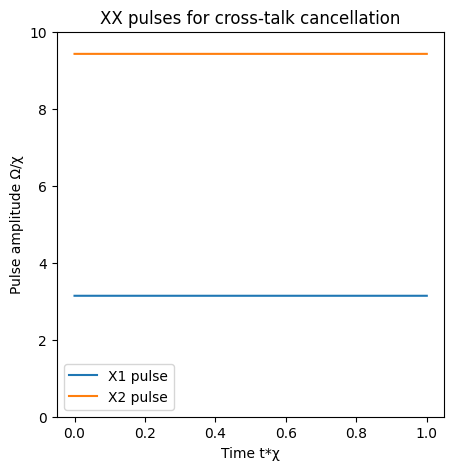

In [42]:
omega_x1, omega_x2= np.loadtxt("pulses/XX_Square_pulses.csv", delimiter=",").T

t_0_1 = np.linspace(0,1, N_points)


fig = plt.figure(figsize=(5, 5))
plt.plot(t_0_1, omega_x1, label = 'X1 pulse')
plt.plot(t_0_1, omega_x2, label = 'X2 pulse')

plt.xlabel("Time t*χ")
plt.ylabel("Pulse amplitude Ω/χ")
plt.title("XX pulses for cross-talk cancellation")
plt.ylim([0,10])
plt.legend();



Test the crosstalk robustness of the XX gate

In [43]:
# normalized parameters
x_X1 = omega_x1 * chi                                               # normalized control along X-axis                                       

x_X2 = omega_x2 * chi                                               # normalized control along X-axis                                       

t_XX = np.linspace(0, 1/chi, N_points)                              # gate time


noise_points = 50

ksi = np.logspace(-3,0, noise_points)                               # noise parameter

ksi_over_chi = ksi * chi


fid_XX_robust      = np.zeros_like(ksi)                             # initialize array for later use
fid_XX_non_robust  = np.zeros_like(ksi)                             # initialize array for later use

for q in range(0,noise_points):

    # ZZ robust
    H_XX_robust = [[X0/2, x_X1],
                   [X1/2, x_X2],
                   [Z0*Z1/2, ksi_over_chi[q]]]
    
    H_XX_robust = qt.QobjEvo(H_XX_robust, tlist= t_XX)           # quantum object 

    result_XX_robust = qt.propagator(H_XX_robust, t = t_XX, args=None, options={'max_step': 0.5/N_points,'atol': 1e-15,'rtol': 1e-15})      # run the simulator 

    fid_XX_robust[q] = np.abs(calculate_gate_fidelity(result_XX_robust[-1], X0*X1))




    # non-robust 
    H_XX_non_robust = [[X0/2, x_X2],
                       [X1/2, x_X2],
                       [Z0*Z1/2, ksi_over_chi[q]]]
    
    H_XX_non_robust = qt.QobjEvo(H_XX_non_robust, tlist= t_XX)           # quantum object 

    result_XX_non_robust = qt.propagator(H_XX_non_robust, t = t_XX, args=None, options={'max_step': 0.5/N_points,'atol': 1e-15,'rtol': 1e-15})      # run the simulator 

    fid_XX_non_robust[q] = np.abs(calculate_gate_fidelity(result_XX_non_robust[-1], X0*X1))
    
    

The figure shown below is Fig.S1 (a) in the paper.

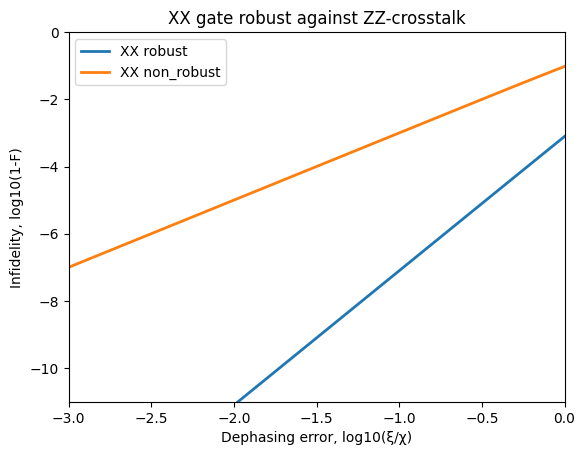

In [45]:
fig, ax = plt.subplots()

ax.plot(np.log10(ksi_over_chi / chi), np.log10( abs(1-fid_XX_robust)), linewidth = 2, label = "XX robust")

ax.plot(np.log10(ksi_over_chi / chi), np.log10( abs(1-fid_XX_non_robust)), linewidth = 2, label = "XX non_robust")

#ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **2  *8), linewidth = 2, label = "2-order")

#ax.plot(np.log10(ksi_over_chi / chi), np.log10( (ksi_over_chi/chi) **4  /1000), linewidth = 2, label = "4-order")


ax.set_xlabel("Dephasing error, log10(ξ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("XX gate robust against ZZ-crosstalk")
ax.set_ylim([-11, 0])
ax.set_xlim([-3, 0])
ax.legend();

# fig.savefig("XX_crosstalk_robust_wrt_chi.svg")

We go back to our main results and we test the dephasing and crosstalk robustness of the $X_1\otimes Z_2$ gate.  

In [48]:
omega_x, omega_tr, phi_tr, delta_tr = np.loadtxt("pulses/XZ_gate_gauss_and_barq.csv", delimiter=",").T

Plot the control fields for transmon, see Fig. 3(b).

C:\Users\dakis\AppData\Local\Temp\ipykernel_27952\163280273.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


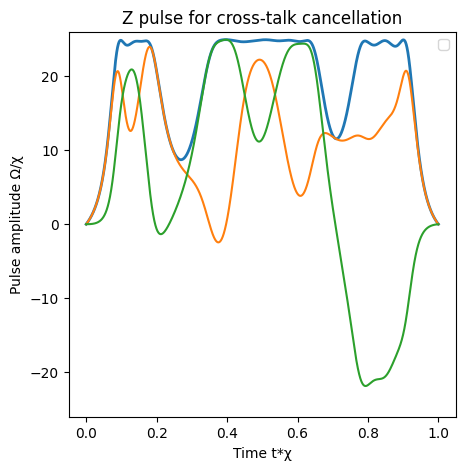

In [49]:
fig = plt.figure(figsize=(5, 5))

plt.plot(t_0_1, omega_tr, linewidth = 2)
plt.plot(t_0_1, omega_tr*np.cos(phi_tr))
plt.plot(t_0_1, omega_tr*np.sin(phi_tr))

plt.ylim([-26,26])

plt.xlabel("Time t*χ")
plt.ylabel("Pulse amplitude Ω/χ")
plt.title("Z pulse for cross-talk cancellation")
plt.legend();

# fig.savefig('gaussian_and_transmon_fields.svg')


In [50]:
t_0_1_chi = np.linspace(0,1/chi, N_points)

# normalized parameters
x_gauss = omega_x * chi                                                         # normalized control along X-axis                                       
 

x_barq = omega_tr * np.cos(phi_tr) * chi                                        # normalized control along X-axis                                       
y_barq = omega_tr * np.sin(phi_tr) * chi                                        # normalized control along Y-axis
z_barq = delta_tr                  * chi                                        # normalized control along Z-axis



H_gauss_barq = [[X0/2, x_gauss], 
                [X1/2, x_barq], [Y1/2, y_barq], [Z1/2, z_barq], [Z0*Z1/2, 0.0]]     # Hamiltonian Eq. (S33) without noise

H_gauss_barq = qt.QobjEvo(H_gauss_barq, tlist=t_0_1_chi)

result_gauss_barq = qt.propagator(H_gauss_barq, t=t_0_1_chi, args=None, options={'max_step': 0.1/N_points,'atol': 1e-14,'rtol': 1e-14})

result_gauss_barq[-1]                   # X_1 Z_2 gate



Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-5.89136780e-15-1.36308618e-12j -2.78238537e-15-8.98179598e-15j
   1.00000000e+00-5.83327296e-07j -1.47586930e-11-2.53286296e-11j]
 [ 2.78238537e-15-8.98179598e-15j -5.89136780e-15+1.36308618e-12j
  -1.47586930e-11+2.53286296e-11j -1.00000000e+00-5.83327296e-07j]
 [ 1.00000000e+00-5.83327296e-07j -1.47586930e-11-2.53286296e-11j
  -5.89136780e-15-1.36308618e-12j -2.78238537e-15-8.98179598e-15j]
 [-1.47586930e-11+2.53286296e-11j -1.00000000e+00-5.83327296e-07j
   2.78238537e-15-8.98179598e-15j -5.89136780e-15+1.36308618e-12j]]

In [51]:
fid_gauss_barq = calculate_gate_fidelity(result_gauss_barq[-1], X0*Z1)      # Fidelity of X_1 Z_2 gate
print(" ----------------- Infidelity ----------------\n")
print("             ",1 - fid_gauss_barq, "\n")
print(" ---------------------------------------------")

 ----------------- Infidelity ----------------

              3.1907809727727e-13 

 ---------------------------------------------


Let's test the robustness of the gate against $Z_2$ dephasing noise. The cell below reproduces Fig. 3(c).

In [53]:
noise_points = 50

gamma = np.logspace(-3,0, noise_points)                              # noise parameter

gamma_over_chi = gamma * chi


fid_XZ         = np.zeros_like(gamma)                               # initialize array for later use
fid_non_robust = np.zeros_like(gamma)                               # initialize array for later use



ksi_over_chi = 0.0 * chi


print("ZZ crosstalk is set ξ/χ = ", ksi_over_chi/chi)

# loop for robust gates
for q in range(0,noise_points):
 
    H_gauss_barq = [[X0/2, x_gauss], 
                    [X1/2, x_barq], [Y1/2, y_barq], [Z1/2, z_barq + gamma_over_chi[q]], 
                    [Z0*Z1/2, ksi_over_chi]]                                                              # Hamlitonian with \gamma *Tg * Z/2 noise ternm

    H_gauss_barq = qt.QobjEvo(H_gauss_barq, tlist=t_0_1_chi)                                                                                 # quantum object

    result_XZ = qt.propagator(H_gauss_barq, t=t_0_1_chi, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})       # run the simulator 

    fid_XZ[q] = np.abs(calculate_gate_fidelity(result_XZ[-1], X0*Z1))    


    # non ZZ robust gate.

    H_non_robust = [[X0/2, 3*np.pi * chi], 
                    [Z1/2, 9*np.pi * chi + gamma_over_chi[q]],
                    [Z0*Z1/2, ksi_over_chi]]

    H_non_robust = qt.QobjEvo(H_non_robust, tlist=t_0_1_chi)

    result_non_robust = qt.propagator(H_non_robust, t=t_0_1_chi, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})

    fid_non_robust[q] = calculate_gate_fidelity(result_non_robust[-1], X0*Z1)




ZZ crosstalk is set ξ/χ =  0.0


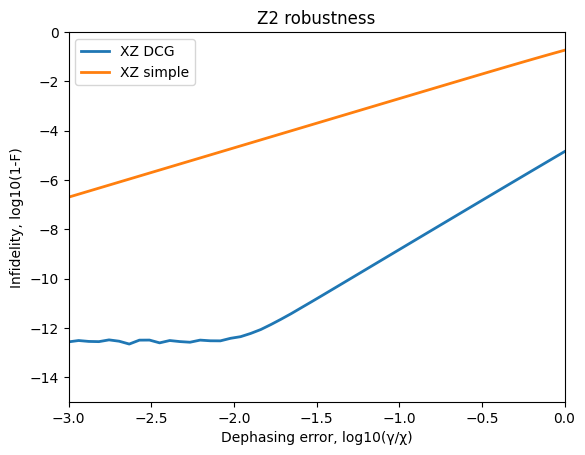

In [54]:

fig, ax = plt.subplots()
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_XZ)), linewidth = 2, label = "XZ DCG")
ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_non_robust)), linewidth = 2, label = "XZ simple")

ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("Z2 robustness")
ax.set_ylim([-15, 0])
ax.set_xlim([-3,  0])
ax.legend();



Let's do the same for the cross-talk robustness

In [55]:
noise_points = 50

ksi = np.logspace(-3,0, noise_points)                              # noise parameter

ksi_over_chi = ksi * chi


fid_XZ         = np.zeros_like(gamma)
fid_non_robust = np.zeros_like(gamma)

gamma_over_chi = 0.0 * chi


print("dephasing is set γ/χ = ", gamma_over_chi/chi)

# loop for robust gates
for q in range(0,noise_points):
 
    H_gauss_barq = [[X0/2, x_gauss], 
                    [X1/2, x_barq], [Y1/2, y_barq], [Z1/2, z_barq + gamma_over_chi], 
                    [Z0*Z1/2, ksi_over_chi[q]]]                                                              # Hamlitonian with \gamma *Tg * Z/2 noise ternm

    H_gauss_barq = qt.QobjEvo(H_gauss_barq, tlist=t_0_1_chi)                                                                                 # quantum object

    result_XZ = qt.propagator(H_gauss_barq, t=t_0_1_chi, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})       # run the simulator 

    fid_XZ[q] = np.abs(calculate_gate_fidelity(result_XZ[-1], X0*Z1))    


    # non ZZ robust gate.

    H_non_robust = [[X0/2, 3*np.pi * chi], 
                    [Z1/2, 9*np.pi * chi + gamma_over_chi],
                    [Z0*Z1/2, ksi_over_chi[q]]]

    H_non_robust = qt.QobjEvo(H_non_robust, tlist=t_0_1_chi)

    result_non_robust = qt.propagator(H_non_robust, t=t_0_1_chi, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})

    fid_non_robust[q] = calculate_gate_fidelity(result_non_robust[-1], X0*Z1)




dephasing is set γ/χ =  0.0


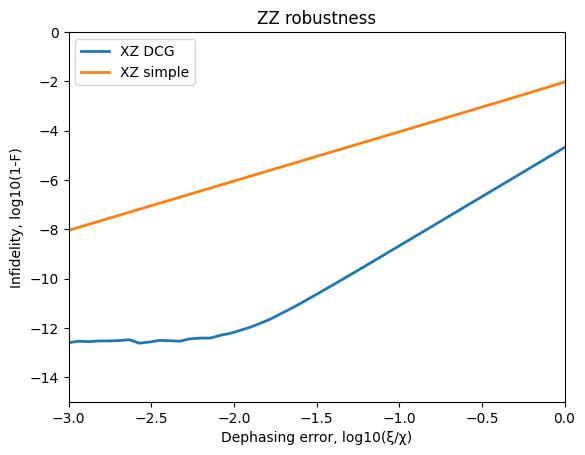

In [56]:
fig, ax = plt.subplots()
ax.plot(np.log10(ksi_over_chi / chi), np.log10( abs(1-fid_XZ)), linewidth = 2, label = "XZ DCG")
ax.plot(np.log10(ksi_over_chi / chi), np.log10( abs(1-fid_non_robust)), linewidth = 2, label = "XZ simple")

ax.set_xlabel("Dephasing error, log10(ξ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("ZZ robustness")
ax.set_ylim([-15, 0])
ax.set_xlim([-3,  0])
ax.legend();


Joint Parity gate for cavity_a1, cavity_b2 and transmon. The photon subspace is {|00>,|01>,|10>,|11>} and the transmon states. For this to happen we assume a couple between cavity_a1 and cavity_2.

In [57]:
H_total_0 = [[X/2, x_control], 
             [Y/2, y_control], 
             [Z/2, z_control]]          # Hamiltonian

H_total_0 = qt.QobjEvo(H_total_0, tlist=time_gate_1)                           # quantum object

result_0 = qt.propagator(H_total_0, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator 
# -----------------------------------------------

# -----------------------------------------------
# Z gate for zero-photon subspace ROBUST

H_g_tr_0 = [[X/2, x_tr], 
            [Y/2, y_tr], 
            [Z/2, z_tr]]

H_g_tr_0 = qt.QobjEvo(H_g_tr_0, tlist = time_g_tr)

result_g_tr_0 = qt.propagator(H_g_tr_0, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
# -----------------------------------------------

# U_jp ZER0-photon subspace FIDELITY
U_JP_0photon = result_0[-1] * result_g_tr_0[-1] * result_0[-1]                              # Matrix 2x2 

""" fid_Ujp_Z_ZZ_robust_0photon[q] = np.abs(calculate_gate_fidelity(U_JP_0photon, I))  """



# one photons -- Robust  Ujp
# -----------------------------------------------
# ZZ(π/2) for single-photon subspace  ROBUST

H_total_1 = [[X1/2, x_control], 
             [Z0*Z1/2, z_control]]       # Hamiltonian with coupling g = 0.

H_total_1 = qt.QobjEvo(H_total_1, tlist= time_gate_1)           # quantum object 

result_1 = qt.propagator(H_total_1, t = time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-15,'rtol': 1e-15})      # run the simulator 
# -----------------------------------------------

# -----------------------------------------------
# XZ gate for single-photon subspace ROBUST

ksi = 0

H_g_tr = [[X0/2, x_g],  [Y0/2,y_g],   [Z0/2, z_g], 
          [X1/2, x_tr], [Y1/2, y_tr], [Z1/2, z_tr ], 
          [Z0*Z1/2, ksi*0]]

H_g_tr = qt.QobjEvo(H_g_tr, tlist = time_g_tr)

result_g_tr = qt.propagator(H_g_tr, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
# -----------------------------------------------

# U_jp single-photon subspace FIDELITY
U_JP_1photon = result_1[-1] * result_g_tr[-1] * result_1[-1]                    # Matrix 2x2     

""" fid_Ujp_Z_ZZ_robust_1photon[q] = np.abs(calculate_gate_fidelity(U_JP_1photon, X0*Z1)) """ 


# --------------- 11 photon subspce -------------------------------

H_total_11 = [[X/2, x_control], 
              [Y/2, y_control], 
              [Z/2, -z_control]]          # Hamiltonian

H_total_11 = qt.QobjEvo(H_total_11, tlist=time_gate_1)                           # quantum object

result_11 = qt.propagator(H_total_11, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator 

H_g_tr_11 = [[X/2, x_tr], 
             [Y/2, y_tr], 
             [Z/2, z_tr]]

H_g_tr_11 = qt.QobjEvo(H_g_tr_11, tlist = time_g_tr)

result_g_tr_11 = qt.propagator(H_g_tr_11, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
# -----------------------------------------------

# U_jp ZER0-photon subspace FIDELITY
U_JP_11photon = result_11[-1] * result_g_tr_11[-1] * result_11[-1] 

# -------------------------------------------------------------------------------------

# ----- Fidelity of the full 8x8 matrix

U_jp_robust_full = qt.Qobj( block_diag(U_JP_0photon.full(), U_JP_1photon.full(), U_JP_11photon.full()))      # Full 8x8 matrix


U_jp_robust_full


Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-1.00000000e+00+9.66300801e-07j -3.55299986e-09-1.57968133e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 3.55299986e-09-1.57968133e-07j -1.00000000e+00-9.66300801e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   3.86100250e-15-4.93587060e-15j  5.50703101e-16-3.29582826e-15j
   1.00000000e+00-5.83326882e-07j -3.55306513e-09-3.59547812e-09j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -5.50703101e-16-3.29582826e-15j  3.8610

Now let's compute the 11 part of the joint parity in the correct way. We write the full hamiltonian for the 2 photon subspace $\{\ket{20},\ket{11},\ket{02}\}$ and at the end we keep only the $\ket{11}$ part and include in the 8x8 evolution operator.

In [59]:
I3 = qt.qeye(3)
Jx = qt.spin_Jx(1)
Jz = qt.spin_Jz(1)


I3_I2  = qt.tensor(I3, I)
J_x    = qt.tensor(Jx, I)
J_z    = qt.tensor(Jz, I)

I3_X1  = qt.tensor(I3, X)
I3_Y1  = qt.tensor(I3, Y)
I3_Z1  = qt.tensor(I3, Z)


H_total_11 = [[I3_X1/2, x_control],
              [I3_Z1/2, -z_control],
              [J_z*I3_Z1/2, -2*z_control]]

H_total_11 = qt.QobjEvo(H_total_11, tlist = time_gate_1)

result_11_6x6 = qt.propagator(H_total_11, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator

result_11_6x6[-1]


Quantum object: dims=[[3, 2], [3, 2]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 6.84435298e-01+6.49268682e-01j -1.49870437e-02+3.31321429e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 1.49870437e-02+3.31321429e-01j  6.84435298e-01-6.49268682e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -7.07106917e-01+7.07106646e-01j  2.53095419e-09-1.11688963e-07j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -2.53095419e-09-1.11688963e-07j -7.07106917e-01-7.07106646e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j 

Extract only the central block matrix

In [60]:
U     = result_11_6x6[-1]               # this is a Qobj
U_mat = U.full()                        # convert to dense numpy array

result_11_2x2 = U_mat[2:4, 2:4]         # extract rows 2..2 and cols 2..2 (Python is 0-based)

result_11_2x2 = qt.Qobj(result_11_2x2)

result_11_2x2

#result_11_2x2 * Z *result_11_2x2


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.07106917e-01+7.07106646e-01j  2.53095419e-09-1.11688963e-07j]
 [-2.53095419e-09-1.11688963e-07j -7.07106917e-01-7.07106646e-01j]]

now let's do the "X_1"Z_2 gate and see what we get. 

In [61]:
ksi = chi/2  *  0.

H_g_tr_11 = [[J_x, omega_x],
             [I3_X1/2, x_tr], 
             [I3_Y1/2, y_tr], 
             [I3_Z1/2, z_tr],
             [I3_Z1/2, -ksi],
             [J_z*I3_Z1/2, -2*ksi]]

H_g_tr_11 = qt.QobjEvo(H_g_tr_11, tlist = time_g_tr)

result_g_tr_11_6x6 = qt.propagator(H_g_tr_11, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})

result_g_tr_11_6x6[-1]

Quantum object: dims=[[3, 2], [3, 2]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 3.01700228e-16+3.66054676e-15j  1.06364615e-16-3.65721559e-16j
  -4.01688395e-15+5.01793797e-15j -5.69651806e-15+2.78403786e-16j
  -5.83326765e-07-1.00000000e+00j -2.63433922e-11+1.63591028e-11j]
 [-1.06364615e-16-3.65721559e-16j  3.01700228e-16-3.66054676e-15j
  -5.69651806e-15-2.78403786e-16j  4.01688395e-15+5.01793797e-15j
   2.63433922e-11+1.63591028e-11j -5.83326765e-07+1.00000000e+00j]
 [-7.14743803e-15+5.46908951e-15j -6.08254558e-15-1.91283141e-16j
  -5.83326766e-07-1.00000000e+00j -2.63430376e-11+1.63601204e-11j
  -7.14743803e-15+5.46908951e-15j -6.08254558e-15-1.91283141e-16j]
 [-6.08254558e-15+1.91283141e-16j  7.14743803e-15+5.46908951e-15j
   2.63430376e-11+1.63601204e-11j -5.83326766e-07+1.00000000e+00j
  -6.08254558e-15+1.91283141e-16j  7.14743803e-15+5.46908951e-15j]
 [-5.83326765e-07-1.00000000e+00j -2.63433922e-11+1.63591028e-11j
  -4.01688395e-15+5.01793797e-15j 

extract only the central 2x2 matrix

In [62]:
U     = result_g_tr_11_6x6[-1]              # this is a Qobj
U_mat = U.full()                            # convert to dense numpy array

result_g_tr_11_2x2 = U_mat[2:4, 2:4]        # extract rows 2..2 and cols 2..2 (Python is 0-based)

result_g_tr_11_2x2 = qt.Qobj(result_g_tr_11_2x2)

result_g_tr_11_2x2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-5.83326766e-07-1.00000000e+00j -2.63430376e-11+1.63601204e-11j]
 [ 2.63430376e-11+1.63601204e-11j -5.83326766e-07+1.00000000e+00j]]

Joint parity sub-block for the |11> state. As we see below, it works fine and as expected leadind to Identity gate!!

In [63]:
result_11_2x2* result_g_tr_11_2x2 * result_11_2x2

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-1.00000000e+00+2.00352748e-07j  3.55296811e-09-1.57935747e-07j]
 [-3.55296811e-09-1.57935747e-07j -1.00000000e+00-2.00352748e-07j]]

Let's see if the $CZ = ZZ(\pi/2)_L$ works fine with an ideal gate $XX(\theta= \pi/2)$. Later we will use a smooth pulse produced using BARQ. 

In [64]:
theta_zz = np.pi/2

X_theta = np.cos(theta_zz/2)*I + -1j*np.sin(theta_zz/2)*X

X_theta

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]

In [65]:
# we do nothing on the cavities, so we need to write the gate as IIX in the 8x8 matrix

X_theta_2x2 = X_theta

X_theta_4x4 = np.cos(theta_zz/2)*II + -1j*np.sin(theta_zz/2)*X1

X_theta_full = qt.Qobj( block_diag(X_theta_2x2.full(), X_theta_4x4.full(), X_theta_2x2.full())) 

X_theta_full

Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.70710678+0.j         0.        -0.70710678j 0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        -0.70710678j 0.70710678+0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.j
  0.        -0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        -0.70710678j
  0.70710678+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.70710678+0.j         0.        -0.70710678j
  0.        +0.j         0.        +0.j        ]
 [0.       

We will need state preparation gates for transmon (see figures), $Y(\pi/4)$ and $Y(-\pi/4)$

In [66]:
Y_pi_4_full = qt.Qobj( block_diag((np.cos(np.pi/4)*I  + 1j*np.sin(np.pi/4)*Y ).full(), 
                                  (np.cos(np.pi/4)*II + 1j*np.sin(np.pi/4)*Y1).full(), 
                                  (np.cos(np.pi/4)*I  + 1j*np.sin(np.pi/4)*Y ).full())) 


Y_minus_pi_4_full = qt.Qobj( block_diag((np.cos(-np.pi/4)*I  + 1j*np.sin(-np.pi/4)*Y ).full(), 
                                        (np.cos(-np.pi/4)*II + 1j*np.sin(-np.pi/4)*Y1).full(), 
                                        (np.cos(-np.pi/4)*I  + 1j*np.sin(-np.pi/4)*Y ).full()))

Now let's add everything together and see if we get the CZ gate

In [67]:

U_JP_11photon_extracted = result_11_2x2* result_g_tr_11_2x2 * result_11_2x2



# Joint parity between cavity_a, and cavity_b using one ancilla

U_jp_robust_full_8x8 = qt.Qobj( block_diag(U_JP_0photon.full(), U_JP_1photon.full(), U_JP_11photon_extracted.full()))      # Full 8x8 matrix

# X_theta gate on the ancilla

X_theta_full;


# CZ = Y(pi/4)    U_jp    X_theta     U_jp    Y(-pi/4)


ZZ_L = Y_pi_4_full * U_jp_robust_full_8x8 * X_theta_full * U_jp_robust_full_8x8 * Y_minus_pi_4_full

# factor out the global phase exp(-1j theta_zz/2)

# ZZ_L = np.exp(1j * theta_zz/2) * CZ


ZZ_L 

Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07107005e-01-7.07106558e-01j  5.02470132e-09+1.36655591e-06j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-5.02470132e-09+1.36655591e-06j  7.07107005e-01+7.07106558e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   7.07106781e-01+7.07106781e-01j  5.02492111e-09+8.24948918e-07j
  -6.11306491e-22+6.44204827e-22j  4.66100781e-15+5.46028684e-15j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -5.02492092e-09+8.24948918e-07j  7.0710

Now, let's do the robustness test against dephasing for the $ZZ(\pi/2)$ gate with the ideal single-qubit gates (I can always use BARQ for them)

In [ ]:
noise_points = 50

gamma = np.logspace(-3,0, noise_points)                              # noise parameter

gamma_over_chi = gamma * chi

fid_ZZ_L = np.zeros_like(gamma)



ksi = 0.0 * chi                                                       # cross-talk on step #2



print("Cross-talk value is ξ/χ = ", ksi/chi)

ZZ_L_target = Y_pi_4_full * U_jp_robust_full_8x8 * X_theta_full * U_jp_robust_full_8x8 * Y_minus_pi_4_full

for q in range(0,noise_points):

    # -----------------------------------------------
    # Rz(π/4) for ZER0-photon subspace  ROBUST

    H_total_0 = [[X/2, x_control], 
                 [Y/2, y_control], 
                 [Z/2, z_control + gamma_over_chi[q]]]          # Hamiltonian

    H_total_0 = qt.QobjEvo(H_total_0, tlist=time_gate_1)                           # quantum object

    result_0 = qt.propagator(H_total_0, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator 
    # -----------------------------------------------

    # -----------------------------------------------
    # Z gate for single-photon subspace ROBUST

    H_g_tr_0 = [[X/2, x_tr], 
                [Y/2, y_tr], 
                [Z/2, z_tr + gamma_over_chi[q]]]

    H_g_tr_0 = qt.QobjEvo(H_g_tr_0, tlist = time_g_tr)

    result_g_tr_0 = qt.propagator(H_g_tr_0, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
    # -----------------------------------------------

    # U_jp ZER0-photon subspace FIDELITY
    U_JP_0photon = result_0[-1] * result_g_tr_0[-1] * result_0[-1]                              # Matrix 2x2 


    # one photons -- Robust  Ujp
    # -----------------------------------------------
    # ZZ(π/2) for single-photon subspace  ROBUST

    H_total_1 = [[X1/2, x_control], 
                 [Z0*Z1/2, z_control + gamma_over_chi[q]]]          # Hamiltonian with coupling g = 0.

    H_total_1 = qt.QobjEvo(H_total_1, tlist= time_gate_1)           # quantum object 

    result_1 = qt.propagator(H_total_1, t = time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-15,'rtol': 1e-15})      # run the simulator 
    # -----------------------------------------------

    # -----------------------------------------------
    # XZ gate for single-photon subspace ROBUST

    H_g_tr = [[X0/2, x_g],  [Y0/2,y_g],   [Z0/2, z_g], 
              [X1/2, x_tr], [Y1/2, y_tr], [Z1/2, z_tr + gamma_over_chi[q]], 
              [Z0*Z1/2, ksi]]

    H_g_tr = qt.QobjEvo(H_g_tr, tlist = time_g_tr)

    result_g_tr = qt.propagator(H_g_tr, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})
    # -----------------------------------------------

    # U_jp single-photon subspace FIDELITY
    U_JP_1photon = result_1[-1] * result_g_tr[-1] * result_1[-1]                            # Matrix 4x4     

    # two-photon subspace -----
   
    H_total_11 = [[I3_X1/2,        x_control],
                  [I3_Z1/2,       -z_control + gamma_over_chi[q]],
                  [J_z*I3_Z1/2, -2*z_control]]

    H_total_11 = qt.QobjEvo(H_total_11, tlist = time_gate_1)

    result_11_6x6 = qt.propagator(H_total_11, t=time_gate_1, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})      # run the simulator

    result_11_2x2 = result_11_6x6[-1].full()[2:4,2:4]           # extract rows 2-3 and cols 2-3 

    result_11_2x2 = qt.Qobj(result_11_2x2)                      # ZZ(pi/2) for the 11 subspace

    # ----------------------------------- XZ part for the 11-subspace
    H_g_tr_11 = [[J_x, omega_x],
                 [I3_X1/2, x_tr], 
                 [I3_Y1/2, y_tr], 
                 [I3_Z1/2, z_tr],
                 [I3_Z1/2, -ksi],
                 [J_z*I3_Z1/2, -2*ksi]]

    H_g_tr_11 = qt.QobjEvo(H_g_tr_11, tlist = time_g_tr)

    result_g_tr_11_6x6 = qt.propagator(H_g_tr_11, t = time_g_tr, args=None, options={'max_step': 0.5/N_points,'atol': 1e-14,'rtol': 1e-14})

    result_g_tr_11_2x2 = result_g_tr_11_6x6[-1].full()[2:4,2:4]          # extract rows 2-3 and cols 2-3 

    result_g_tr_11_2x2 = qt.Qobj(result_g_tr_11_2x2)                     # XZ for the 11 subspace which is actually IZ for the 11-subspace

    U_JP_11photon = result_11_2x2* result_g_tr_11_2x2 * result_11_2x2    # U_jpfor 11-subspace
    



    # ----- Fidelity of the full 6x6 matrix

    U_jp_robust_8x8 = qt.Qobj( block_diag(U_JP_0photon.full(), U_JP_1photon.full(), U_JP_11photon.full() ) )      # Full 8x8 matrix

    ZZ_L = Y_pi_4_full * U_jp_robust_8x8 * X_theta_full * U_jp_robust_8x8 * Y_minus_pi_4_full               # ZZ_L robust 

    fid_ZZ_L[q] = np.abs(calculate_gate_fidelity(ZZ_L, ZZ_L_target))
    
  

Cross-talk value is ξ/χ =  0.0


' ax = fig.add_subplot(122)\n\nax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_Z_ZZ_full)), linewidth = 2, label = "Ujp - robust ")\n\nax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_sqr_full)), linewidth = 2, label = "Ujp - sqr pls yale ")\n\nax.set_xlabel("Dephasing error, log10(γ/χ)")\nax.set_ylabel("Infidelity, log10(1-F)")\nax.set_title("Joint Parity (B)")\nax.set_ylim([-13, 0])\nax.set_xlim([-3, 0])\nax.legend(); '

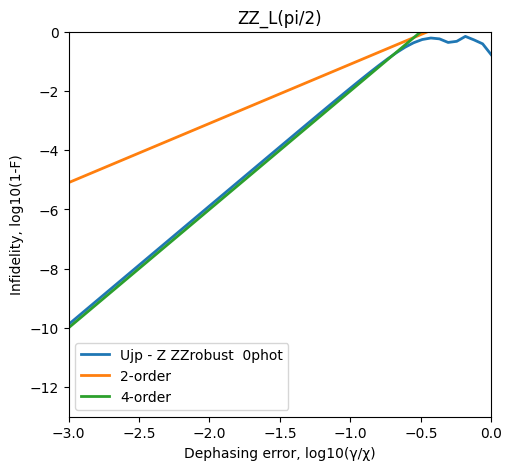

In [69]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_ZZ_L)), linewidth = 2, label = "Ujp - Z ZZrobust  0phot")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **2  *8), linewidth = 2, label = "2-order")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **4  *100), linewidth = 2, label = "4-order")

#ax.plot(np.log10(gamma_over_chi / chi), np.log10( (gamma_over_chi/chi) **6  /1000), linewidth = 2, label = "6-order")

ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("ZZ_L(pi/2)")
ax.set_ylim([-13, 0])
ax.set_xlim([-3, 0])
ax.legend();


""" ax = fig.add_subplot(122)

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_Z_ZZ_full)), linewidth = 2, label = "Ujp - robust ")

ax.plot(np.log10(gamma_over_chi / chi), np.log10( abs(1-fid_Ujp_sqr_full)), linewidth = 2, label = "Ujp - sqr pls yale ")

ax.set_xlabel("Dephasing error, log10(γ/χ)")
ax.set_ylabel("Infidelity, log10(1-F)")
ax.set_title("Joint Parity (B)")
ax.set_ylim([-13, 0])
ax.set_xlim([-3, 0])
ax.legend(); """


# fig.savefig("ZZ_L_dephasing_wrt_chi__step2_ksi_1chi.svg")